In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input/keras-pretrained-models/"))

from PIL import Image

import xml.etree.ElementTree as ET

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

# Any results you write to the current directory are saved as output.

In [2]:
# x_model = keras.applications.Xception()
# x_model.summary()

### Gather Data

In [3]:
images_dir = os.path.abspath('../input/stanford-dogs-dataset/images/Images')
data_dir = os.path.abspath('data')
inception_resNet_weights = os.path.abspath('../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
resNet_weights = os.path.abspath('../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
inception_weights = os.path.abspath('../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
annotations_dir = os.path.abspath('../input/stanford-dogs-dataset/annotations/Annotation')
vgg_16_weights = os.path.abspath('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
densenet_weights = os.path.abspath('../input/densenet-keras/DenseNet-BC-121-32-no-top.h5')
xception_weights = os.path.abspath('../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

### Define our hyperparameters

In [4]:
WIDTH = 75
HEIGHT = 75
CHANNELS = 3
LEARNING_RATE = 1e-4
EPOCHS = 500
BATCH_SIZE = 64
NUM_CLASSES = 0

In [5]:
breed_list = os.listdir("../input/stanford-dogs-dataset/images/Images/")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("../input/stanford-dogs-dataset/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


In [6]:
%%time
#import shutil
#shutil.rmtree("data")
if not os.path.exists('data'):
    os.mkdir('data')
    for breed in breed_list:
        os.mkdir('data/' + breed)
    print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

    for breed in os.listdir('data'):
        for file in os.listdir('../input/stanford-dogs-dataset/annotations/Annotation/{}'.format(breed)):
            img = Image.open('../input/stanford-dogs-dataset/images/Images/{}/{}.jpg'.format(breed, file))
            tree = ET.parse('../input/stanford-dogs-dataset/annotations/Annotation/{}/{}'.format(breed, file))
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((224, 224))
            img.save('data/' + breed + '/' + file + '.jpg')

Created 120 folders to store cropped images of the different breeds.
CPU times: user 1min 54s, sys: 6.57 s, total: 2min 1s
Wall time: 3min 30s


### Define function to gather images and labels

In [7]:
from glob import glob

def get_images_labels(directory):
    labels_images = {}
    for _dir in glob(directory + '/*'):
        images = []
        curr_label = os.path.basename(_dir)
        for _file in glob(directory + '/' + curr_label + '/*.jpg'):
            images.append(_file)
            
        labels_images.setdefault(curr_label, images)
        
    return labels_images

labels_images = get_images_labels(data_dir)

In [8]:
NUM_CLASSES = len(labels_images)

### Define function to preprocess images

In [9]:
from PIL import Image

def preprocess_images(dictionary, width = WIDTH, height = HEIGHT):
    images = []
    labels = []
    for k,v in dictionary.items():
        for path in v:
            img = Image.open(path)
            img = img.convert('RGB')
            img = img.resize((height, width))
            img = np.asarray(img)
            img = img / 255.
            
            images.append(img)
            labels.append(str(k.split('-')[1].lower()))
    
    return np.array(images), np.array(labels)

images, labels = preprocess_images(labels_images)
    
print('images shape:',images.shape)
print('labels shape:',labels.shape)

images shape: (20580, 75, 75, 3)
labels shape: (20580,)


### Display some images w/ labels

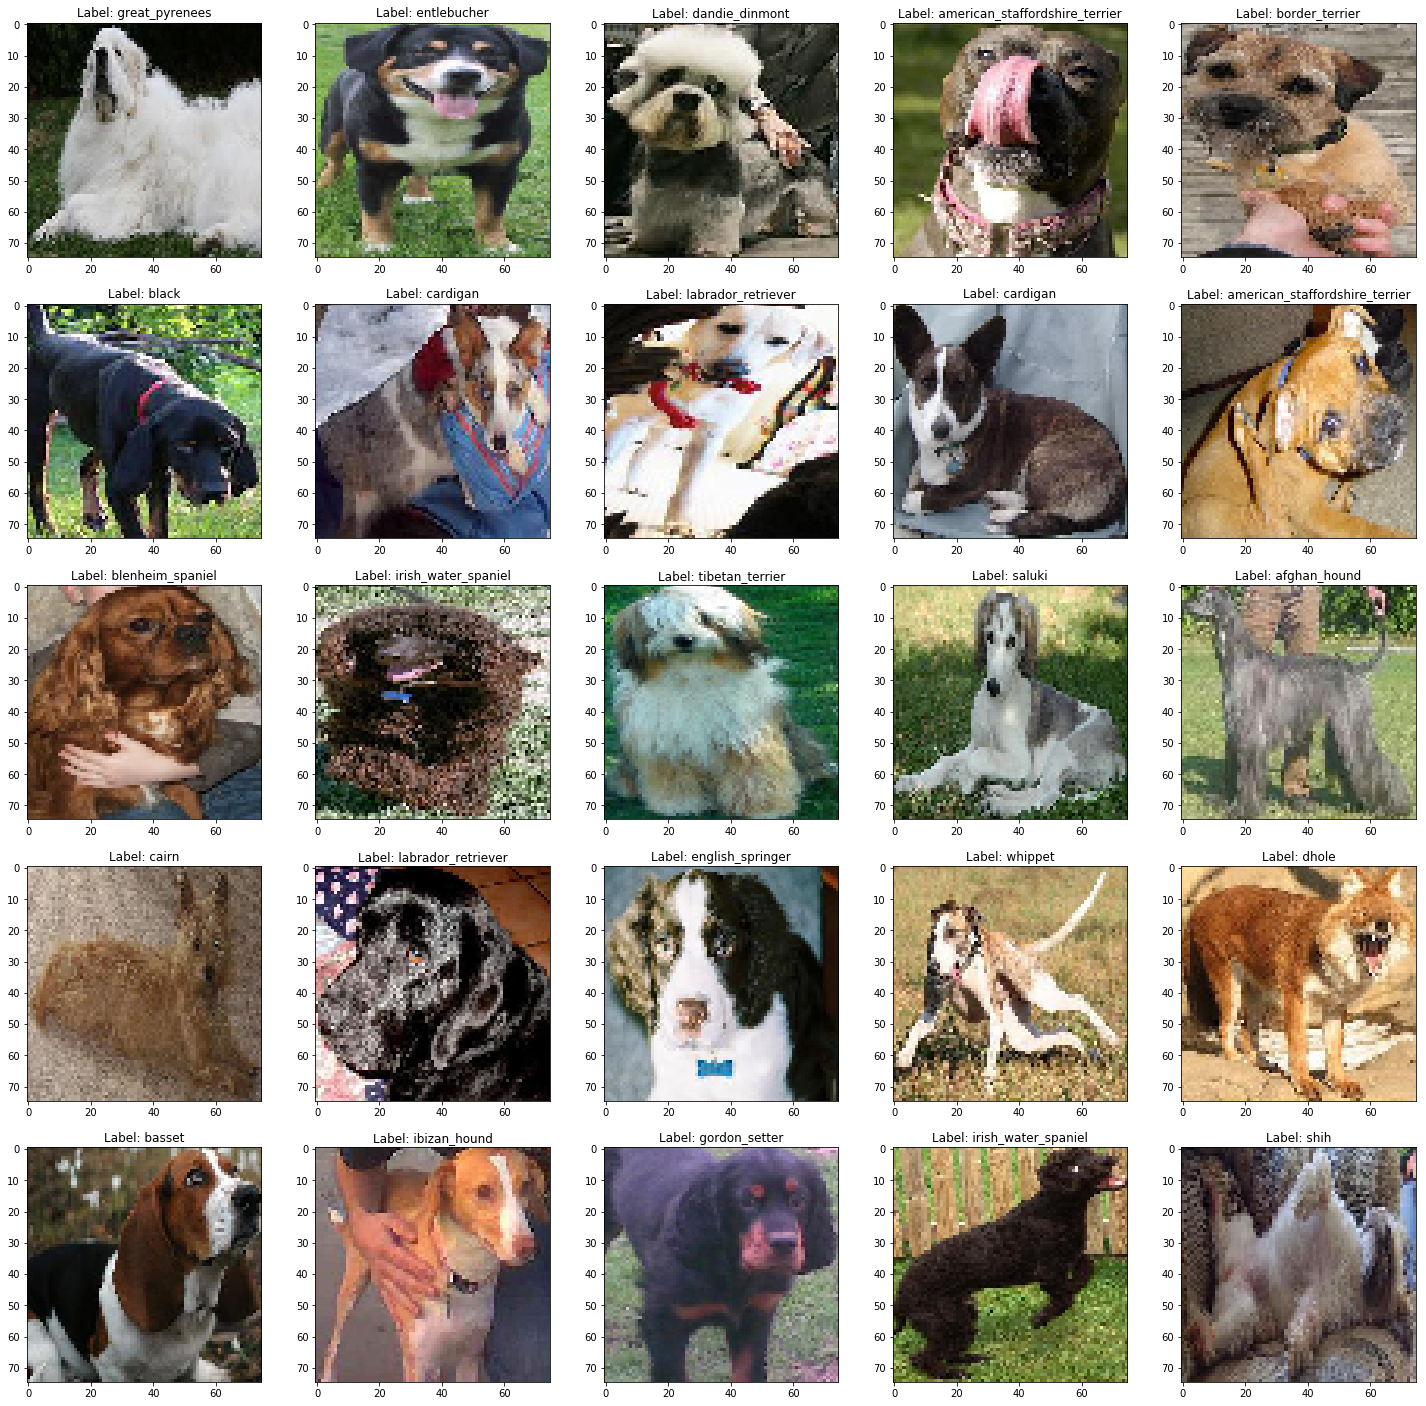

In [10]:
import matplotlib.pyplot as plt

def display_images(images, labels, num_images = 25):
    plt.figure(figsize = (25,25))
    for i in range(num_images):
        index = np.random.randint(0,images.shape[0])
        plt.subplot(5,5,i+1)
        plt.imshow(images[index])
        plt.title('Label: {}'.format(str(labels[index])))
        
    plt.show()
    
display_images(images, labels)

### Convert our labels to categorical values

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded, NUM_CLASSES)

print('labels shape:',labels_encoded.shape)

Using TensorFlow backend.


labels shape: (20580, 120)


### Build our model

In [12]:
import keras

#inception_base = keras.applications.InceptionV3(include_top=False, weights=inception_weights, input_shape= (HEIGHT, WIDTH, CHANNELS))
#vgg16_base = keras.applications.vgg16.VGG16(include_top = False, weights = vgg_16_weights, input_shape = (HEIGHT, WIDTH, CHANNELS))
densenet_base = keras.applications.densenet.DenseNet121(include_top = False, weights = densenet_weights, input_shape = (HEIGHT, WIDTH, CHANNELS))
#xception_base = keras.applications.xception.Xception(include_top = False, weights = xception_weights, input_shape = (HEIGHT, WIDTH, CHANNELS))
#resNet_base = keras.applications.ResNet50(include_top = False, weights = resNet_weights, input_shape = (HEIGHT, WIDTH, CHANNELS))
#incep_res_base = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights=inception_resNet_weights, input_shape=(HEIGHT, WIDTH, CHANNELS))

def build_model():
    
    backbone = densenet_base
    backbone_output = backbone.output
  
    X = keras.layers.GlobalAveragePooling2D()(backbone_output)
    
    X = keras.layers.Dense(1024)(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    
    X = keras.layers.Dense(1024)(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    
    X = keras.layers.Dense(512)(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    
    X = keras.layers.Dense(NUM_CLASSES)(X)
    outputs = keras.layers.Activation('softmax')(X)
    
    model = keras.models.Model(inputs = backbone.input, outputs = outputs)

    return model


Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model = build_model()
# for layer in model.layers[:-9]:
#     layer.trainable = False

model.compile(optimizer = keras.optimizers.Adam(lr = LEARNING_RATE), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 81, 81, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 38, 38, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1/conv[0][0]            

### Split our data into a training/development/testing set

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_dev, Y_train, Y_dev = train_test_split(images, labels_encoded, test_size = 0.2, random_state = 1029)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.35, random_state = 1029)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_dev shape:', X_dev.shape)
print('Y_dev shape:', Y_dev.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (10701, 75, 75, 3)
Y_train shape: (10701, 120)
X_dev shape: (4116, 75, 75, 3)
Y_dev shape: (4116, 120)
X_test shape: (5763, 75, 75, 3)
Y_test shape: (5763, 120)


### Augment our data

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range = 45,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

dev_datagen = ImageDataGenerator(rotation_range = 45,
                                 width_shift_range = 0.2,
                                 height_shift_range = 0.2,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 horizontal_flip = True)

train_gen = train_datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE)

dev_gen = dev_datagen.flow(X_dev, Y_dev, batch_size = BATCH_SIZE)

train_steps = train_gen.n // BATCH_SIZE
dev_steps = dev_gen.n // BATCH_SIZE

### Create our callbacks

In [16]:
log_dir = 'logs'
if not os.path.isdir(log_dir): os.mkdir(log_dir)
    
model_checkpoint_dir = 'checkpoints'
if not os.path.isdir(model_checkpoint_dir): os.mkdir(model_checkpoint_dir)

In [17]:
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = 1),
             keras.callbacks.TensorBoard(log_dir = './logs', histogram_freq = 0, batch_size = BATCH_SIZE, write_graph = True, write_grads = True, write_images = False),
             keras.callbacks.ModelCheckpoint(filepath = model_checkpoint_dir + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor = 'val_loss', save_best_only = True, verbose = 1, period = 25),
             keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", patience=5, verbose=1)
            ]


### Train our model

In [18]:
history = model.fit_generator(train_gen,
                              steps_per_epoch = train_steps,
                              epochs = EPOCHS,
                              validation_data = dev_gen,
                              validation_steps = dev_steps,
                              callbacks = callbacks,
                              verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
 - 64s - loss: 5.1211 - acc: 0.0116 - val_loss: 4.7848 - val_acc: 0.0134
Epoch 2/500
 - 42s - loss: 4.8522 - acc: 0.0100 - val_loss: 4.7858 - val_acc: 0.0106
Epoch 3/500
 - 42s - loss: 4.8137 - acc: 0.0095 - val_loss: 4.7881 - val_acc: 0.0121
Epoch 4/500
 - 42s - loss: 4.8014 - acc: 0.0109 - val_loss: 4.7828 - val_acc: 0.0188
Epoch 5/500
 - 41s - loss: 4.7929 - acc: 0.0119 - val_loss: 4.7735 - val_acc: 0.0227
Epoch 6/500
 - 42s - loss: 4.7681 - acc: 0.0149 - val_loss: 4.7248 - val_acc: 0.0242
Epoch 7/500
 - 42s - loss: 4.6824 - acc: 0.0216 - val_loss: 4.5573 - val_acc: 0.0205
Epoch 8/500
 - 41s - loss: 4.5936 - acc: 0.0237 - val_loss: 4.4566 - val_acc: 0.0380
Epoch 9/500
 - 40s - loss: 4.4672 - acc: 0.0358 - val_loss: 4.2858 - val_acc: 0.0597
Epoch 10/500
 - 41s - loss: 4.3333 - acc: 0.0468 - val_loss: 4.0644 - val_acc: 0.0814
Epoch 11/500
 - 40s - loss: 4.1056 - acc: 0.0695 - val_loss: 3.7455 - val_acc: 0.1088
Epoch 12/500
 -

### Plot our metrics

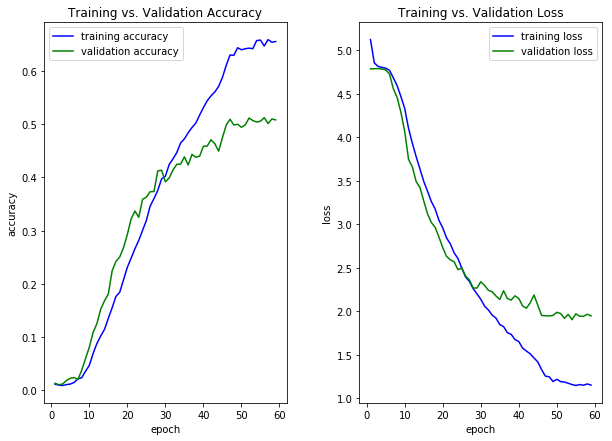

In [19]:
def display_metrics_graph(history):
    acc, val_acc, loss, val_loss = history.history['acc'], history.history['val_acc'], history.history['loss'], history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize = (10,7))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, c = 'b', label = 'training accuracy')
    plt.plot(epochs, val_acc, c = 'g', label = 'validation accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, c = 'b', label = 'training loss')
    plt.plot(epochs, val_loss, c = 'g', label = 'validation loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    plt.subplots_adjust(wspace=0.3, hspace=0.2)
    plt.show()
        
display_metrics_graph(history)

### Evaluate our model on our test set

In [20]:
eval_loss, eval_acc = model.evaluate(X_test, Y_test)
print('Evaluation Loss: {}, Evaluation Accuracy: {}'.format(eval_loss, eval_acc * 100))

5763/5763 [==============================] - 4s 767us/step
Evaluation Loss: 1.903045869248, Evaluation Accuracy: 51.58771473191046
